# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading
2. Dictionary generation
3. Data preprocessing
4. Model (neural network) training
5. Text generation (model evaluation)

### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

**Alternatively**

You could use file `onegin.txt` with Russian texts or your natve language poetry to be able to assess results quality.

**Note: In case of Onegin text you need to adjust reading procedure yourself!!!** (this file has a bit different format than `sonnets.txt`)

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/sonnets.txt
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/onegin.txt

--2025-01-11 18:31:50--  https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2025-01-11 18:31:51 (4.70 MB/s) - ‘sonnets.txt’ saved [119748/119748]

--2025-01-11 18:31:51--  https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.

In [ ]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
import string

In [ ]:
text = ''.join(text).lower()

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
PAD_TOKEN = " "
END_TOKEN = "\n"

token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

In [ ]:
token_to_idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 ':': 9,
 ';': 10,
 '?': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [ ]:
def text_to_matrix(
    text: str,
    pad: int = token_to_idx[PAD_TOKEN],
    end: int = token_to_idx[END_TOKEN],
    dtype=np.int64,
    batch_first: bool = True,
):
    text_idx = np.full(len(text), token_to_idx[PAD_TOKEN], np.int64)

    for i, char in enumerate(text):
        text_idx[i] = token_to_idx[char]


    return text_idx

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
emb_size = 16

In [ ]:
Embedding = nn.Embedding(len(tokens), emb_size)

In [ ]:
matrix_text = text_to_matrix(text)
batch = torch.from_numpy(matrix_text).type(torch.int64).unsqueeze(0)
emb = Embedding(batch)

In [ ]:
batch.size()

torch.Size([1, 100225])

In [ ]:
class CharRNNCell(nn.Module):
    """Implement the scheme above as torch module"""

    def __init__(self, num_tokens=len(tokens), embedding_size=emb_size, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        # TODO init with normal distribution and make it trainable
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """Computes log P(next_character) for all time-steps in names_ix

    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call our one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

In [ ]:
print(batch.shape)

logp_seq = rnn_loop(char_rnn, batch)
logp_seq.shape

torch.Size([1, 100225])


torch.Size([1, 100225, 38])

In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to
# get its view of desired shape.

loss = criterion(
    predictions_logp.contiguous().view(-1, len(tokens)),
    actual_next_tokens.contiguous().view(-1),
)

loss.backward()

In [ ]:
def calculate_accuracy(predictions, targets):
    pred_inds = torch.argmax(predictions, dim=-1)  # Выбираем наиболее вероятные символы
    accuracy = (pred_inds == targets).sum().item() / targets.numel()  # Доля правильных предсказаний
    return accuracy

In [ ]:
from random import sample

from IPython.display import clear_output

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
# opt = torch.optim.SGD(char_rnn.parameters())
batch_size = 64
num_iterations = 2000
num_epochs = 10

history_loss = []
history_acc = []

for epoch in range(num_epochs):
    print(epoch)
    epoch_loss = 0
    epoch_accuracy = 0
    for i in range(num_iterations):
        opt.zero_grad()

        batch_ix = text_to_matrix(sample(text, batch_size))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).unsqueeze(0)

        logp_seq = rnn_loop(char_rnn, batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = criterion(
            predictions_logp.contiguous().view(-1, len(tokens)),
            actual_next_tokens.contiguous().view(-1),
        )

        # train with backprop
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
        accuracy = calculate_accuracy(predictions_logp, actual_next_tokens)
        epoch_accuracy += accuracy

    avg_epoch_loss = epoch_loss / num_iterations
    avg_epoch_accuracy = epoch_accuracy / num_iterations
    history_loss.append(avg_epoch_loss)
    history_acc.append(avg_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


Plot the loss function (axis X: number of epochs, axis Y: loss function).

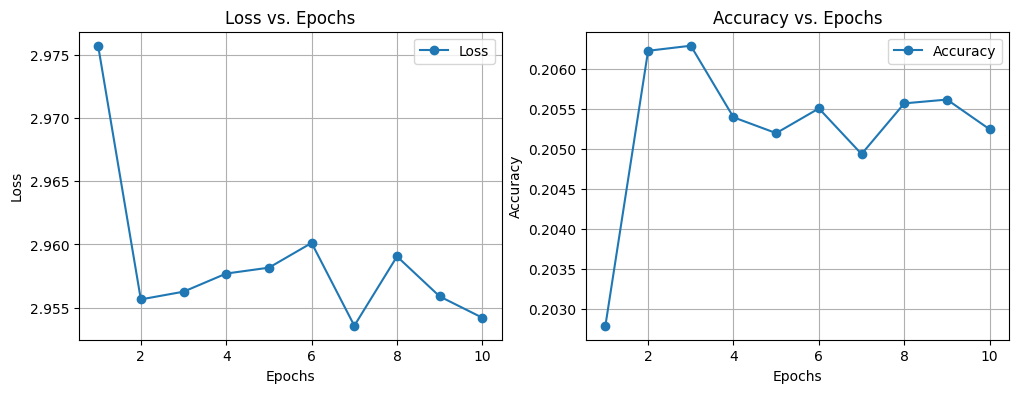

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(range(1, num_epochs + 1), history_loss, marker='o', label="Loss")
axes[0].set_title("Loss vs. Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(range(1, num_epochs + 1), history_acc, marker='o', label="Accuracy")
axes[1].set_title("Accuracy vs. Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.show()

In [ ]:
# Your plot code here

In [ ]:
# An example of generated text. There is no function `generate_text` in the code above.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


In [ ]:
def generate_sample(char_rnn, seed_phrase, max_length=100, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# for _ in range(10):
print(generate_sample(char_rnn, seed_phrase='hall', temperature=0.8))

hallma,onmreoh l yee  ot 
  dui hrim t hdfi n n ton  avaotas  e se r eseiae f srw te fl  e m wci   y


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `(0.1, 0.2, 0.5, 1.0, 2.0)`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text.
Follow guides from [this tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

You need to use `Save/Load state_dict (Recommended)` section aka save state dict.

In [ ]:
# Saving and loading code here

## Additional materials on topic

1. [Andrew Karpathy blog post about RNN.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)\
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with [PyTorch examples](https://github.com/spro/practical-pytorch`)